In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json, itertools
import pandas as pd
import scipy.optimize as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py

In [46]:
run_dir = "output/pre_09_03_23/"
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
log_file[-20:]

,L,steps,a,b,w,n_runs,ts
49,70,4860,0.1,0.105,2.2,240,1678164816
50,70,4860,0.1,0.105,2.4,240,1678165471
51,70,4860,0.1,0.105,2.6,240,1678166190
52,70,4860,0.1,0.105,2.8,240,1678167009
53,70,4860,0.1,0.105,3.0,240,1678167954
54,70,4860,0.1,0.105,3.2,240,1678169028
55,70,4860,0.1,0.105,3.4,240,1678170280
56,90,8035,0.1,0.105,1.0,240,1678171392
57,90,8035,0.1,0.105,1.2,240,1678172491
58,90,8035,0.1,0.105,1.4,240,1678173578


In [73]:
ts = str(ts_list[63])

with open(run_dir+"Ising_2D_output_"+ts+".pkl", "rb") as fp:   # Unpickling
    output_data = pickle.load(fp)

with open(run_dir+"Ising_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
    
Omegas = np.array([])
dec_types = np.array([])
h_array, J_array = [], []


for core, item in enumerate(output_data):
    J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
    Omegas = np.concatenate((Omegas, Omega_list_composite))
    dec_types = np.concatenate((dec_types, decimation_type_composite))
    if core==0:
        h_array = h_dist_list
        J_array = J_dist_list

    else:
        for i in range(len(input_dict['measure_list'])):
            h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
            J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
        
        
with open(run_dir+"Ising_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
print(input_dict)

{'L': 90, 'steps': 8035, 'measure_list': array([8100, 6288, 4881, 3790, 2942, 2284, 1773, 1376, 1068,  829,  644,
        500,  388,  301,  234,  181,  141,  109,   85,   65]), 'a': 0.1, 'b': 0.105, 'w': 2.3999999999999995, 'n_runs': 240}


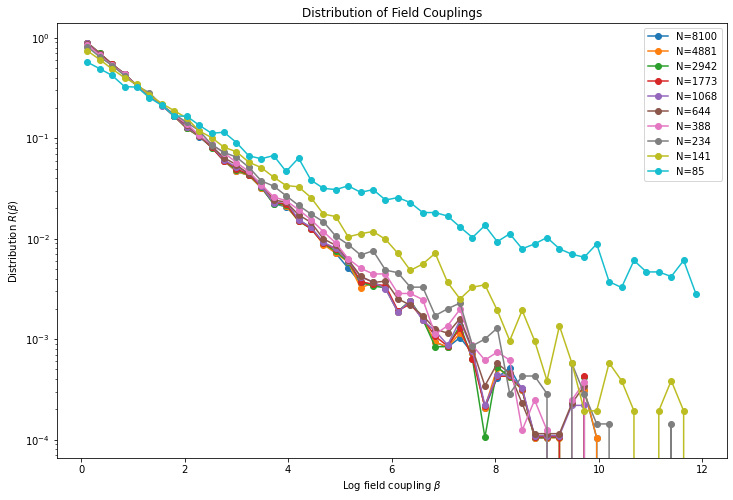

In [70]:
measure_list = input_dict['measure_list']
L = input_dict['L']
spins_left = L*L - measure_list
n_runs = input_dict['n_runs']
n_bins_h = 50
width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list[:-1]): 
    n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)
    y = n
    if i%2==0: plt.plot(x, y, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x[:20], y[:20])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_list.append(1/popt[0])

plt.yscale('log')
#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
#plt.yscale('log')
plt.legend()

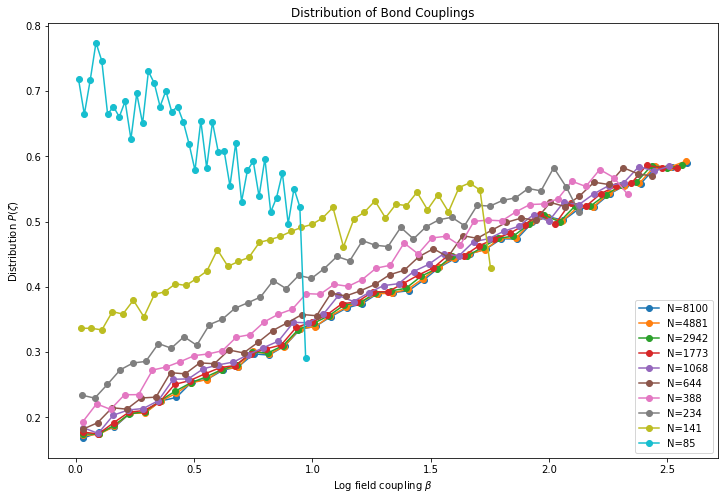

In [71]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_J = 40
plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list[:-1]): 
    n,bins = np.histogram(J_dist_list[i], density=True, bins = n_bins_J)
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)/width_list[i]
    y = n
    if i%2==0: plt.plot(x, y, label="N="+str(step), marker='o')



#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $P(\zeta)$")
plt.title("Distribution of Bond Couplings")

plt.legend()

[ 0.57382738 20.74002446]


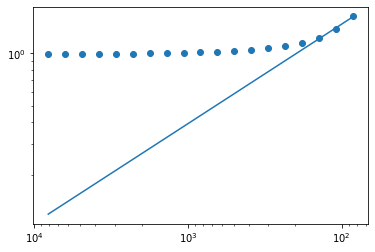

In [72]:
plt.scatter(measure_list[:-1], width_list)
x = measure_list[:-1]

popt, pcov = curve_fit(power_law_scale, x[-3:], width_list[-3:])
plt.plot(x, power_law_scale(x, *popt))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
print(popt)

#Note: Improve fitting on the distribution, I think that's where your issue is coming from

In [33]:
L = 60
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

w_vals = fixed_length_slice['w'].tolist()
largest_clust_size = []
var_lcs = [] 
c_list = []
c_dict = {60:'red', 80:'blue', 100:'green'}

for index, ts in enumerate(ts_list):

    with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []
    
    largest_clust_list  = []
    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp
        #largest_clust_list+=[max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_list_temp]

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_list = np.array(largest_clust_list)
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    #var_lcs.append(largest_clust_list.std()/L**2)
    c_list.append(c_dict[L])

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

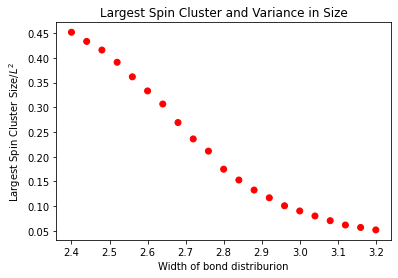

In [34]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.scatter(w_vals, largest_clust_size, c=c_list)
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")


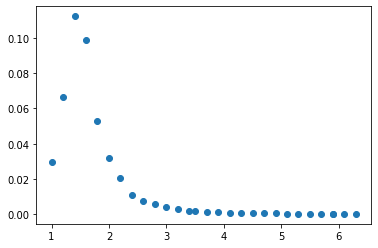

In [41]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))
plt.scatter(sorted_x, sorted_y)


In [3]:
L_list = [60, 80, 100]
c_dict = {60:'red', 80:'blue', 100:'green'}


w_vals_comp = []
lcs_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    largest_clust_size = []
    var_lcs = [] 
    c_list = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        #c_list.append(c_dict[L])
    
    w_vals_comp.append(w_vals)
    lcs_comp.append(largest_clust_size)
    

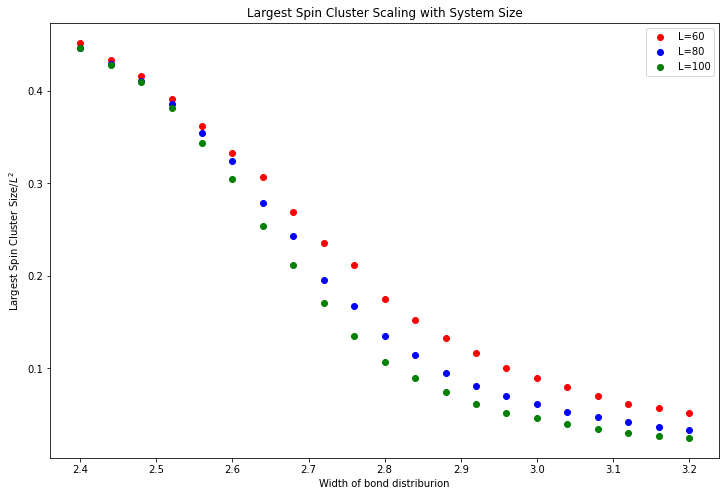

In [9]:
plt.figure(figsize=(12, 8))

for i, L in enumerate(L_list):
    plt.scatter(w_vals_comp[i], lcs_comp[i], c=c_dict[L], label='L='+str(L))
    
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()

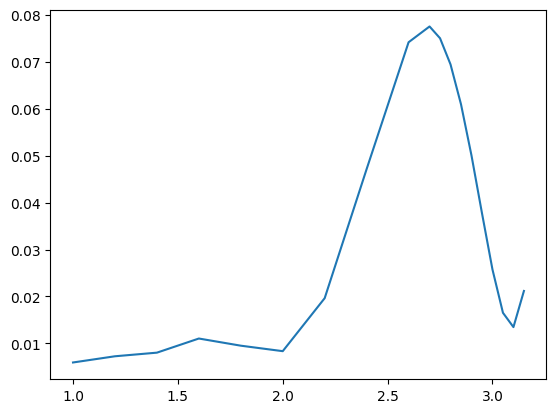

In [21]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))

poly_degree = 7

poly = PolynomialFeatures(degree = poly_degree)
poly_features = poly.fit_transform(sorted_x.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, sorted_y)
y_predicted = poly_reg_model.predict(poly_features)

plt.plot(sorted_x, y_predicted)

[0.58600978 1.84757256]


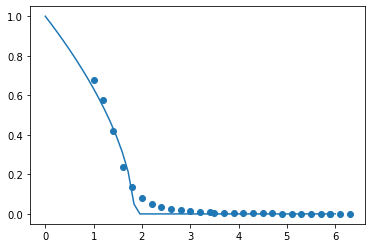

In [37]:
x = np.linspace(0, 6)

def order_param_func(x, scaling, crit_point):
    return np.piecewise(x, [x < crit_point, x >= crit_point], [lambda x: (1-x/crit_point)**scaling, 0])


popt, pcov = curve_fit(order_param_func, w_vals, largest_clust_size)

plt.plot(x, order_param_func(x, *popt))
plt.scatter(w_vals, largest_clust_size)
print(popt)

In [5]:
def check_percolation(clust_dict, L, width):
    end_point = int(L/2)
    for y1 in range(L):
        for y1_width in range(-width, width+1):
            for y2 in range(L):
                for y2_width in range(-width, width+1):
                    start_ind = index_map(y1_width%L, y1, L)
                    end_index = index_map((end_point+y2_width)%L, y2, L)
                    if (clust_dict[start_ind] == clust_dict[end_index]): 
                        return True
    return False
        

Text(0.5, 1.0, 'Percolation Transition')

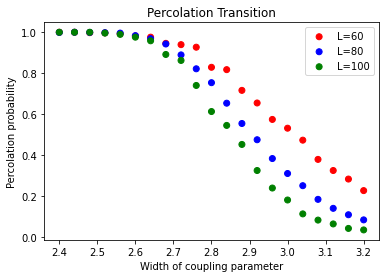

In [10]:
for L in [60, 80, 100]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()

    p_perc_clust = []
    c_list = []
    #color_dict = {50:'blue', 60:'red', 40:'green'}

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation(clust, L, 2) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        c_list.append(c_dict[L])
   
    plt.scatter(w_vals, p_perc_clust, c=c_list, label="L="+str(L))
    

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

In [25]:
L_list = [60, 80, 100]#, 70, 85, 50]
clust_size_list_comp = []
clust_size_list_bdry_comp = []
w_vals_comp = []
run_dir = "run_set_1/"
log_file = pd.read_csv(run_dir+"log_file.csv")

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    clust_size_list = []
    clust_dict_list_bdry = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
        
        clust_sizes = np.array(list(itertools.chain.from_iterable([[len(clust) for clust in rd.values() if clust is not None] for rd in reverse_dict_list])))
        #List of sizes of all clusters normalized to system size       
        clust_size_list.append(clust_sizes[clust_sizes!=1]/L**2)

    w_vals_comp.append(w_vals)
    clust_size_list_comp.append(clust_size_list)

Text(0.5, 1.0, 'Distribution of Cluster Sizes')

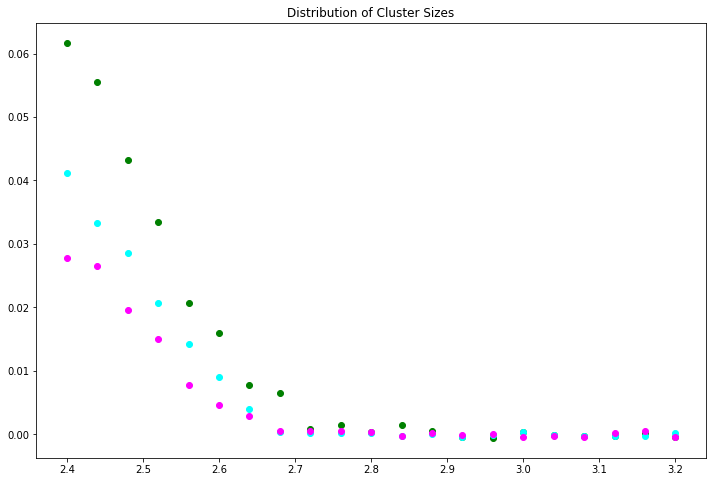

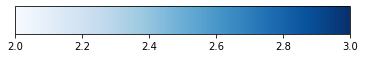

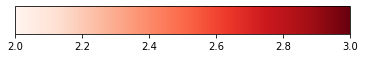

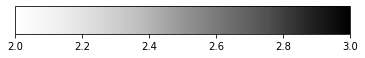

In [27]:
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

fig, ax0 = plt.subplots(figsize=(12, 8))

c_dict = {50:'red', 70:'blue', 60:'green', 80:'cyan', 30:'orange', 100:'magenta', 85:'orange'}
cmap_type = {50:'Greens', 60:'Blues', 80:'Reds', 100:'Greys'}
for ind, L in enumerate(L_list):
    curve_check = []
    mean_clust_size = []
    cdf_max = []
    for index, w in enumerate(w_vals_comp[ind]):
        #if not index%3==0: continue
        #if not index==3: continue    
        cmap_L = cm.get_cmap(cmap_type[L])
        norm = plt.Normalize(2, 3)
        hist, bin_edges = np.histogram(clust_size_list_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        #ax0.plot(bin_edges[1:]-width/2, hist,color=cmap_L(norm(w)), marker='o')
        
        
        cdf = np.cumsum(hist)
        #ax0.plot(x,cdf, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(cdf, 1)
        #ax0.plot(x, smooth, color=cmap_L(norm(w)), linestyle='--')
        second_der = np.gradient(np.gradient(smooth))
        #ax1 = ax0.twinx()
        #ax1.plot(x,second_der, color=cmap_L(norm(w)))
        a = np.diff(np.sign(np.diff(second_der))).nonzero()[0] + 1   
        #plt.scatter(x[a], second_der[a])
        infl_size = second_der[a[-2]]-second_der[a[-1]]
        curve_check.append(infl_size)
        #cdf_max.append(cdf[-1])
        #Attempt at doing statistics on cluster sizes
        """
        cs_list = clust_size_list_comp[ind][index]
        cs_list = cs_list[cs_list>(0.8*L/(L*L))]
        mean_clust_size.append(np.median(cs_list))
        """
        
        #Attempt at checking concavity of the distribution to identify transition
        """
        raw = np.log(hist)[5:]
        ax0.plot(raw, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(raw, 1)
        ax0.plot(smooth, color=cmap_L(norm(w)), linestyle='--')
        smooth_d1 = np.gradient(smooth[smooth>-4])
        curve_check.append(np.sum(smooth_d1))
        """
        
        #hist, bin_edges = np.histogram(clust_size_list_bdry_comp[ind][index], density=True, bins=20)
        #width = bin_edges[1]-bin_edges[0]
        #ax0.plot(bin_edges[1:]-width/2, hist,color=cmap_L(norm(w)), marker='^', linestyle='--')
    
    #ax0.plot(w_vals_comp[ind], mean_clust_size, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], cdf_max, c=c_dict[L], marker='o')
    ax0.scatter(w_vals_comp[ind], curve_check, c=c_dict[L], marker='o')
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_L,
                                norm=norm,
                                orientation='horizontal')
    
ax0.set_title("Distribution of Cluster Sizes")
#ax0.xscale('log')
#ax0.set_yscale('log')
#plt.legend()

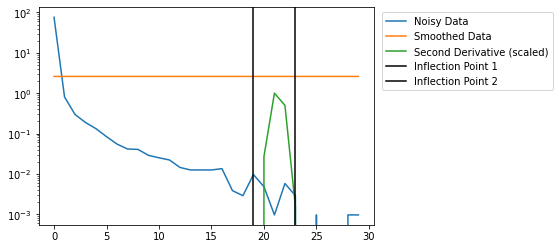

In [22]:
from scipy.ndimage import gaussian_filter1d


np.random.seed(0)

# generate noisy data
raw = hist

# smooth
smooth = gaussian_filter1d(raw, 200)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.plot(raw, label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
plt.legend(bbox_to_anchor=(1.55, 1.0))

plt.yscale('log')

In [39]:
L_list = [50]
c_dict = {50:'red', 80:'blue', 100:'green'}


w_vals_comp = []
moment_array_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    mean_moment_list = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        moment_list_comp = []

        for core_pair in clust_list_final:
            moment_list_temp = core_pair[2]
            moment_list_comp+=moment_list_temp
        
        mean_moment_list.append(np.array(moment_list_comp).mean(axis=0))
    
    w_vals_comp.append(w_vals)
    moment_array_comp.append(mean_moment_list)

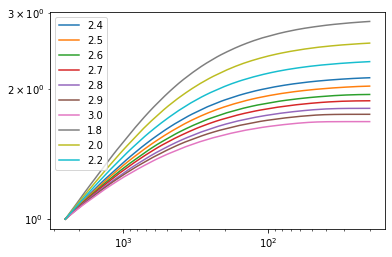

In [40]:
for ind, L in enumerate(L_list):
    for index, w in enumerate(w_vals_comp[ind]):
        y_data = moment_array_comp[ind][index]
        x_axis = L*L - np.arange(len(y_data))
        plt.plot(x_axis, y_data, label=str(w))

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()